In [60]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [61]:
#Get tweets data
client = MongoClient('mongodb://localhost:27017/')
db = client["project2"]
collection = db['output']
results = list(collection.find())

## Preparing the sentiment data 

In [62]:
# Convert the results into a DataFrame
df = pd.DataFrame(results)

# Separate sentiment counts by month
sentiment_counts_by_date = df.groupby('date')['sentiment'].value_counts().unstack(fill_value=0)

# Calculate proportions
sentiment_proportions = sentiment_counts_by_date.div(sentiment_counts_by_date.sum(axis=1), axis=0)

# Display proportions
print("Sentiment Proportions by Date:")
print(sentiment_proportions)

Sentiment Proportions by Date:
sentiment   negative  neutral  positive
date                                   
22/11/2024      0.50     0.40      0.10
23/11/2024      0.55     0.35      0.10
24/11/2024      0.60     0.25      0.15


In [63]:
sentiment_proportions = pd.DataFrame(sentiment_proportions, index=['24/11/2024', '23/11/2024', '22/11/2024'])

# Reset index to turn 'month' into a column
sentiment_proportions = sentiment_proportions.reset_index()

# Rename the index column to 'month'
sentiment_proportions = sentiment_proportions.rename(columns={'index': 'date'})

# Map months to numeric values
sentiment_proportions['date_encoded'] = sentiment_proportions['date'].map({"24/11/2024": 1, "23/11/2024": 2, "22/11/2024": 3})

# Display the updated DataFrame
sentiment_proportions

sentiment,date,negative,neutral,positive,date_encoded
0,24/11/2024,0.60,0.25,0.15,1
1,23/11/2024,0.55,0.35,0.10,2
2,22/11/2024,0.50,0.40,0.10,3


## Build and train the model

In [64]:
# Features (X) and target (Y) setup
X = sentiment_proportions[['date_encoded']]  # Only month_encoded as the feature
y_negative = sentiment_proportions['negative']
y_neutral = sentiment_proportions['neutral']
y_positive = sentiment_proportions['positive']

In [65]:
# Train model for negative sentiment
model_negative = LinearRegression()
model_negative.fit(X, y_negative)

# Train model for neutral sentiment
model_neutral = LinearRegression()
model_neutral.fit(X, y_neutral)

# Train model for positive sentiment
model_positive = LinearRegression()
model_positive.fit(X, y_positive)


LinearRegression()

## Prediction output for 25 November 2024

In [66]:
nextday = pd.DataFrame({
    'date_encoded': [4]  # Assuming 'date_encoded' is a feature used by the model
})
# Predict sentiment proportions for 25 November 2024
predicted_negative = model_negative.predict(nextday)
predicted_neutral = model_neutral.predict(nextday)
predicted_positive = model_positive.predict(nextday)

#Create a DataFrame for 25/11/2024 predictions
nextday_df = pd.DataFrame({
    'date': ['25/11/2024'],
    'negative': [predicted_negative[0]],
    'neutral': [predicted_neutral[0]],
    'positive': [predicted_positive[0]],
    'date_encoded': [4]
})

# Set pandas to display floats with 2 significant figures
pd.options.display.float_format = '{:.2f}'.format
# Append the next day predictions to the existing sentiment proportions DataFrame
final_df = pd.concat([sentiment_proportions, nextday_df], ignore_index=True)

# Display the combined DataFrame
final_df

,date,negative,neutral,positive,date_encoded
0,24/11/2024,0.60,0.25,0.15,1
1,23/11/2024,0.55,0.35,0.10,2
2,22/11/2024,0.50,0.40,0.10,3
3,25/11/2024,0.45,0.48,0.07,4


## Visualisation 

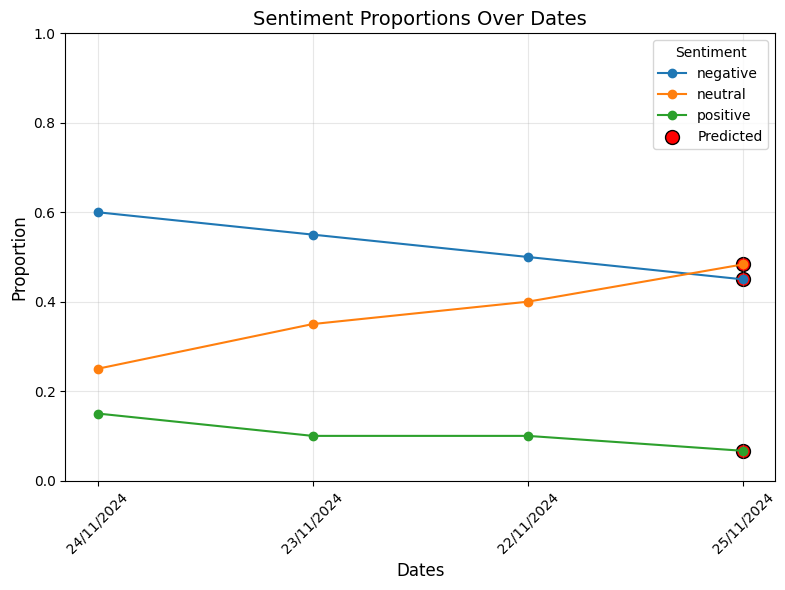

In [67]:
# Plot the sentiment proportions
plt.figure(figsize=(8, 6))

# Plot lines for each sentiment
for sentiment in ['negative', 'neutral', 'positive']:
    plt.plot(final_df['date'], final_df[sentiment], label=sentiment, marker='o')

# Highlight next day data
lastday_row = final_df[final_df['date'] == '25/11/2024']
for sentiment in ['negative', 'neutral', 'positive']:
    plt.scatter(
        lastday_row['date'], 
        lastday_row[sentiment], 
        color='red', 
        label=f"Predicted" if sentiment == 'negative' else None,  # Avoid duplicate legend entries
        s=100, 
        edgecolor='black'
    )

# Customize the plot
plt.title('Sentiment Proportions Over Dates', fontsize=14)
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.ylim(0, 1)  # Sentiment proportions range from 0 to 1
plt.xticks(rotation=45)
plt.legend(title='Sentiment', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()
